see `mpf_rsi_demo.py`

In [1]:
# This allows multiple outputs from a single jupyter notebook cell:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
%matplotlib inline
import pandas as pd

import numpy as np

import mplfinance as mpf

In [3]:
def relative_strength(prices, n=14):
    """
    compute the n period relative strength indicator
    http://stockcharts.com/school/doku.php?id=chart_school:glossary_r#relativestrengthindex
    http://www.investopedia.com/terms/r/rsi.asp
    """
    deltas = np.diff(prices)
    seed = deltas[:n + 1]
    up = seed[seed >= 0].sum() / n
    down = -seed[seed < 0].sum() / n
    rs = up / down
    rsi = np.zeros_like(prices)
    rsi[:n] = 100. - 100. / (1. + rs)

    for i in range(n, len(prices)):
        delta = deltas[i - 1]  # cause the diff is 1 shorter

        if delta > 0:
            upval = delta
            downval = 0.
        else:
            upval = 0.
            downval = -delta

        up = (up * (n - 1) + upval) / n
        down = (down * (n - 1) + downval) / n

        rs = up / down
        rsi[i] = 100. - 100. / (1. + rs)

    return rsi

def _ta_RSI(df, n=14):
    # https://github.com/wgong/mplfinance/blob/master/examples/rsi.py
#     diff = df.Close.diff().values
    diff = df.w_p.diff().values
    gains = diff
    losses = -diff
    with np.errstate(invalid='ignore'):
        gains[(gains<0)|np.isnan(gains)] = 0.0
        losses[(losses<=0)|np.isnan(losses)] = 1e-10 # we don't want divide by zero/NaN
    m = (n-1) / n
    ni = 1 / n
    g = gains[n] = np.nanmean(gains[:n])
    l = losses[n] = np.nanmean(losses[:n])
    gains[:n] = losses[:n] = np.nan
    for i,v in enumerate(gains[n:],n):
        g = gains[i] = ni*v + m*g
    for i,v in enumerate(losses[n:],n):
        l = losses[i] = ni*v + m*l
    rs = gains / losses
#     df['rsi'] = 100 - (100/(1+rs))
    return 100 - (100/(1+rs))

In [4]:
infile = "data/SPY_20110701_20120630_Bollinger.csv"
# "data/yahoofinance-AAPL-20040819-20180120.csv"  # 'data/yahoofinance-SPY-20200901-20210113.csv'
# (3379, 6)
df = pd.read_csv(infile, index_col=0, parse_dates=True)
# df = pd.read_csv(infile, index_col=0, parse_dates=True).iloc[-400:]


In [5]:
df.shape

(252, 9)

In [6]:
df.columns

Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'UpperB',
       'LowerB', 'PercentB'],
      dtype='object')

In [24]:
df.drop(columns=["rsi_shift"], axis=1, inplace=True)

In [13]:
df.head()

,Open,High,Low,Close,Volume,w_p,rsi
Date,,,,,,,
2011-07-01,132.089996,134.100006,131.779999,133.919998,202385700,133.430000,NaN
2011-07-05,133.779999,134.080002,133.389999,133.809998,165936000,133.772499,NaN
2011-07-06,133.490005,134.139999,133.110001,133.970001,143331600,133.797501,NaN
2011-07-07,135.160004,135.699997,134.880005,135.360001,170464200,135.325001,NaN
2011-07-08,133.830002,135.360001,133.389999,134.399994,194100500,134.387497,NaN


In [10]:
RSI_PERIOD = 20

In [11]:
df["w_p"] = 0.25*(2*df['Close'] + df['High'] + df['Low'])

In [35]:
# df['rsi'] = relative_strength(df['w_p'],n=RSI_PERIOD)

df['rsi'] = _ta_RSI(df,n=RSI_PERIOD) - 50
df["rsi_avg"] = df.rsi.ewm(span=3).mean()

In [47]:
df["rsi_diff"] = df.rsi.diff()
df["rsi_diff_1"] = df.rsi_diff.shift()
df["rsi_turn"] = 0.2*df.rsi_diff * df.rsi_diff_1

In [48]:
df.tail(10)

,Open,High,Low,Close,Volume,w_p,rsi,rsi_diff,rsi_diff_1,rsi_turn,rsi_turn_avg,rsi_avg
Date,,,,,,,,,,,,
2012-06-18,133.580002,134.729996,133.279999,134.399994,131360900,134.202496,1.593900,0.869101,2.034621,0.353658,2.214043,0.263694
2012-06-19,135.080002,136.250000,134.369995,135.699997,137382600,135.504997,5.290295,3.696396,0.869101,0.642508,2.713292,2.776995
2012-06-20,135.710007,136.100006,134.270004,135.479996,206451800,135.332501,4.707914,-0.582382,3.696396,-0.430542,0.280290,3.742454
2012-06-21,135.639999,135.779999,132.330002,132.440002,205272200,133.247501,-1.757415,-6.465329,-0.582382,0.753058,2.022789,0.992520
2012-06-22,133.130005,133.710007,132.619995,133.460007,130029200,133.312504,-1.557459,0.199956,-6.465329,-0.258556,0.365004,-0.282470
2012-06-25,132.050003,132.100006,130.850006,131.320007,146375700,131.397507,-6.740195,-5.182736,0.199956,-0.207264,-0.335657,-3.511332
2012-06-26,131.699997,132.380005,130.929993,131.979996,141634000,131.817498,-5.372545,1.367649,-5.182736,-1.417633,-3.711911,-4.441939
2012-06-27,132.419998,133.429993,131.970001,133.169998,108088000,132.934998,-1.870752,3.501793,1.367649,0.957845,0.538657,-3.156346
2012-06-28,132.289993,132.990005,131.279999,132.789993,169242100,132.462497,-3.188343,-1.317591,3.501793,-0.922786,-2.037637,-3.172344


In [ ]:
df = df.iloc[-df.shape[0]+RSI_PERIOD:] 

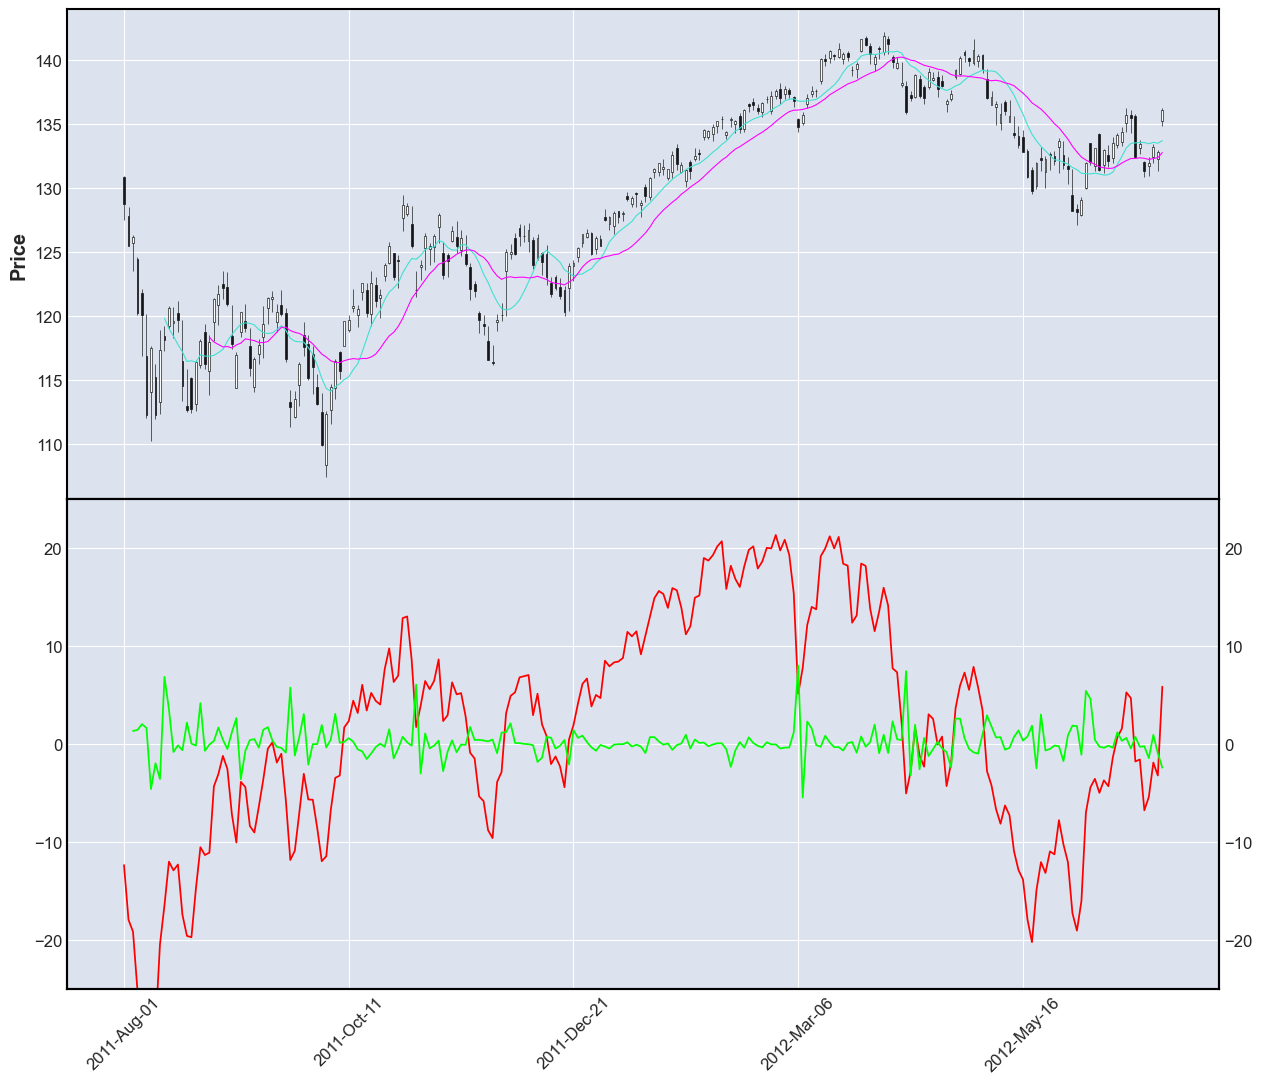

In [51]:
# apd = mpf.make_addplot(df['rsi'],panel=1,color='lime',ylim=(30,90),secondary_y=True)
apd1 = mpf.make_addplot(df['rsi'],panel=1,color='red',ylim=(-25,25) )
apd2 = mpf.make_addplot(df['rsi_turn'],panel=1,color='lime',ylim=(-25,25) )
# apd1a = mpf.make_addplot(df['rsi_avg'],panel=1,color='r' )
mpf.plot(df,type='candle',volume=False,mav=(10,20), addplot=[apd1,apd2],panel_ratios=(1,1), figsize=(16,14))

## profile  functions

In [26]:
%%timeit
df['rsi'] = relative_strength(df['w_p'],n=RSI_PERIOD)  
# 548 µs ± 28.5 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)   90 rows

# 1.75 ms ± 30.2 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each) 400 rows

1.75 ms ± 30.2 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
